In [1]:
import tensorflow as tf 
from tensorflow import keras    
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import Read_Data as rs
import tqdm
from matplotlib.animation import FuncAnimation 
import tensorflow_addons as tfa

d:\BraiNeoCare\.venv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

d:\BraiNeoCare\.venv\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and s

Extracting EDF parameters from d:\BraiNeoCare\Datasets\zenodo_eeg\eeg22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[ 224  631 3013 3472 3698] [ 281  719 3107 3491 3751]


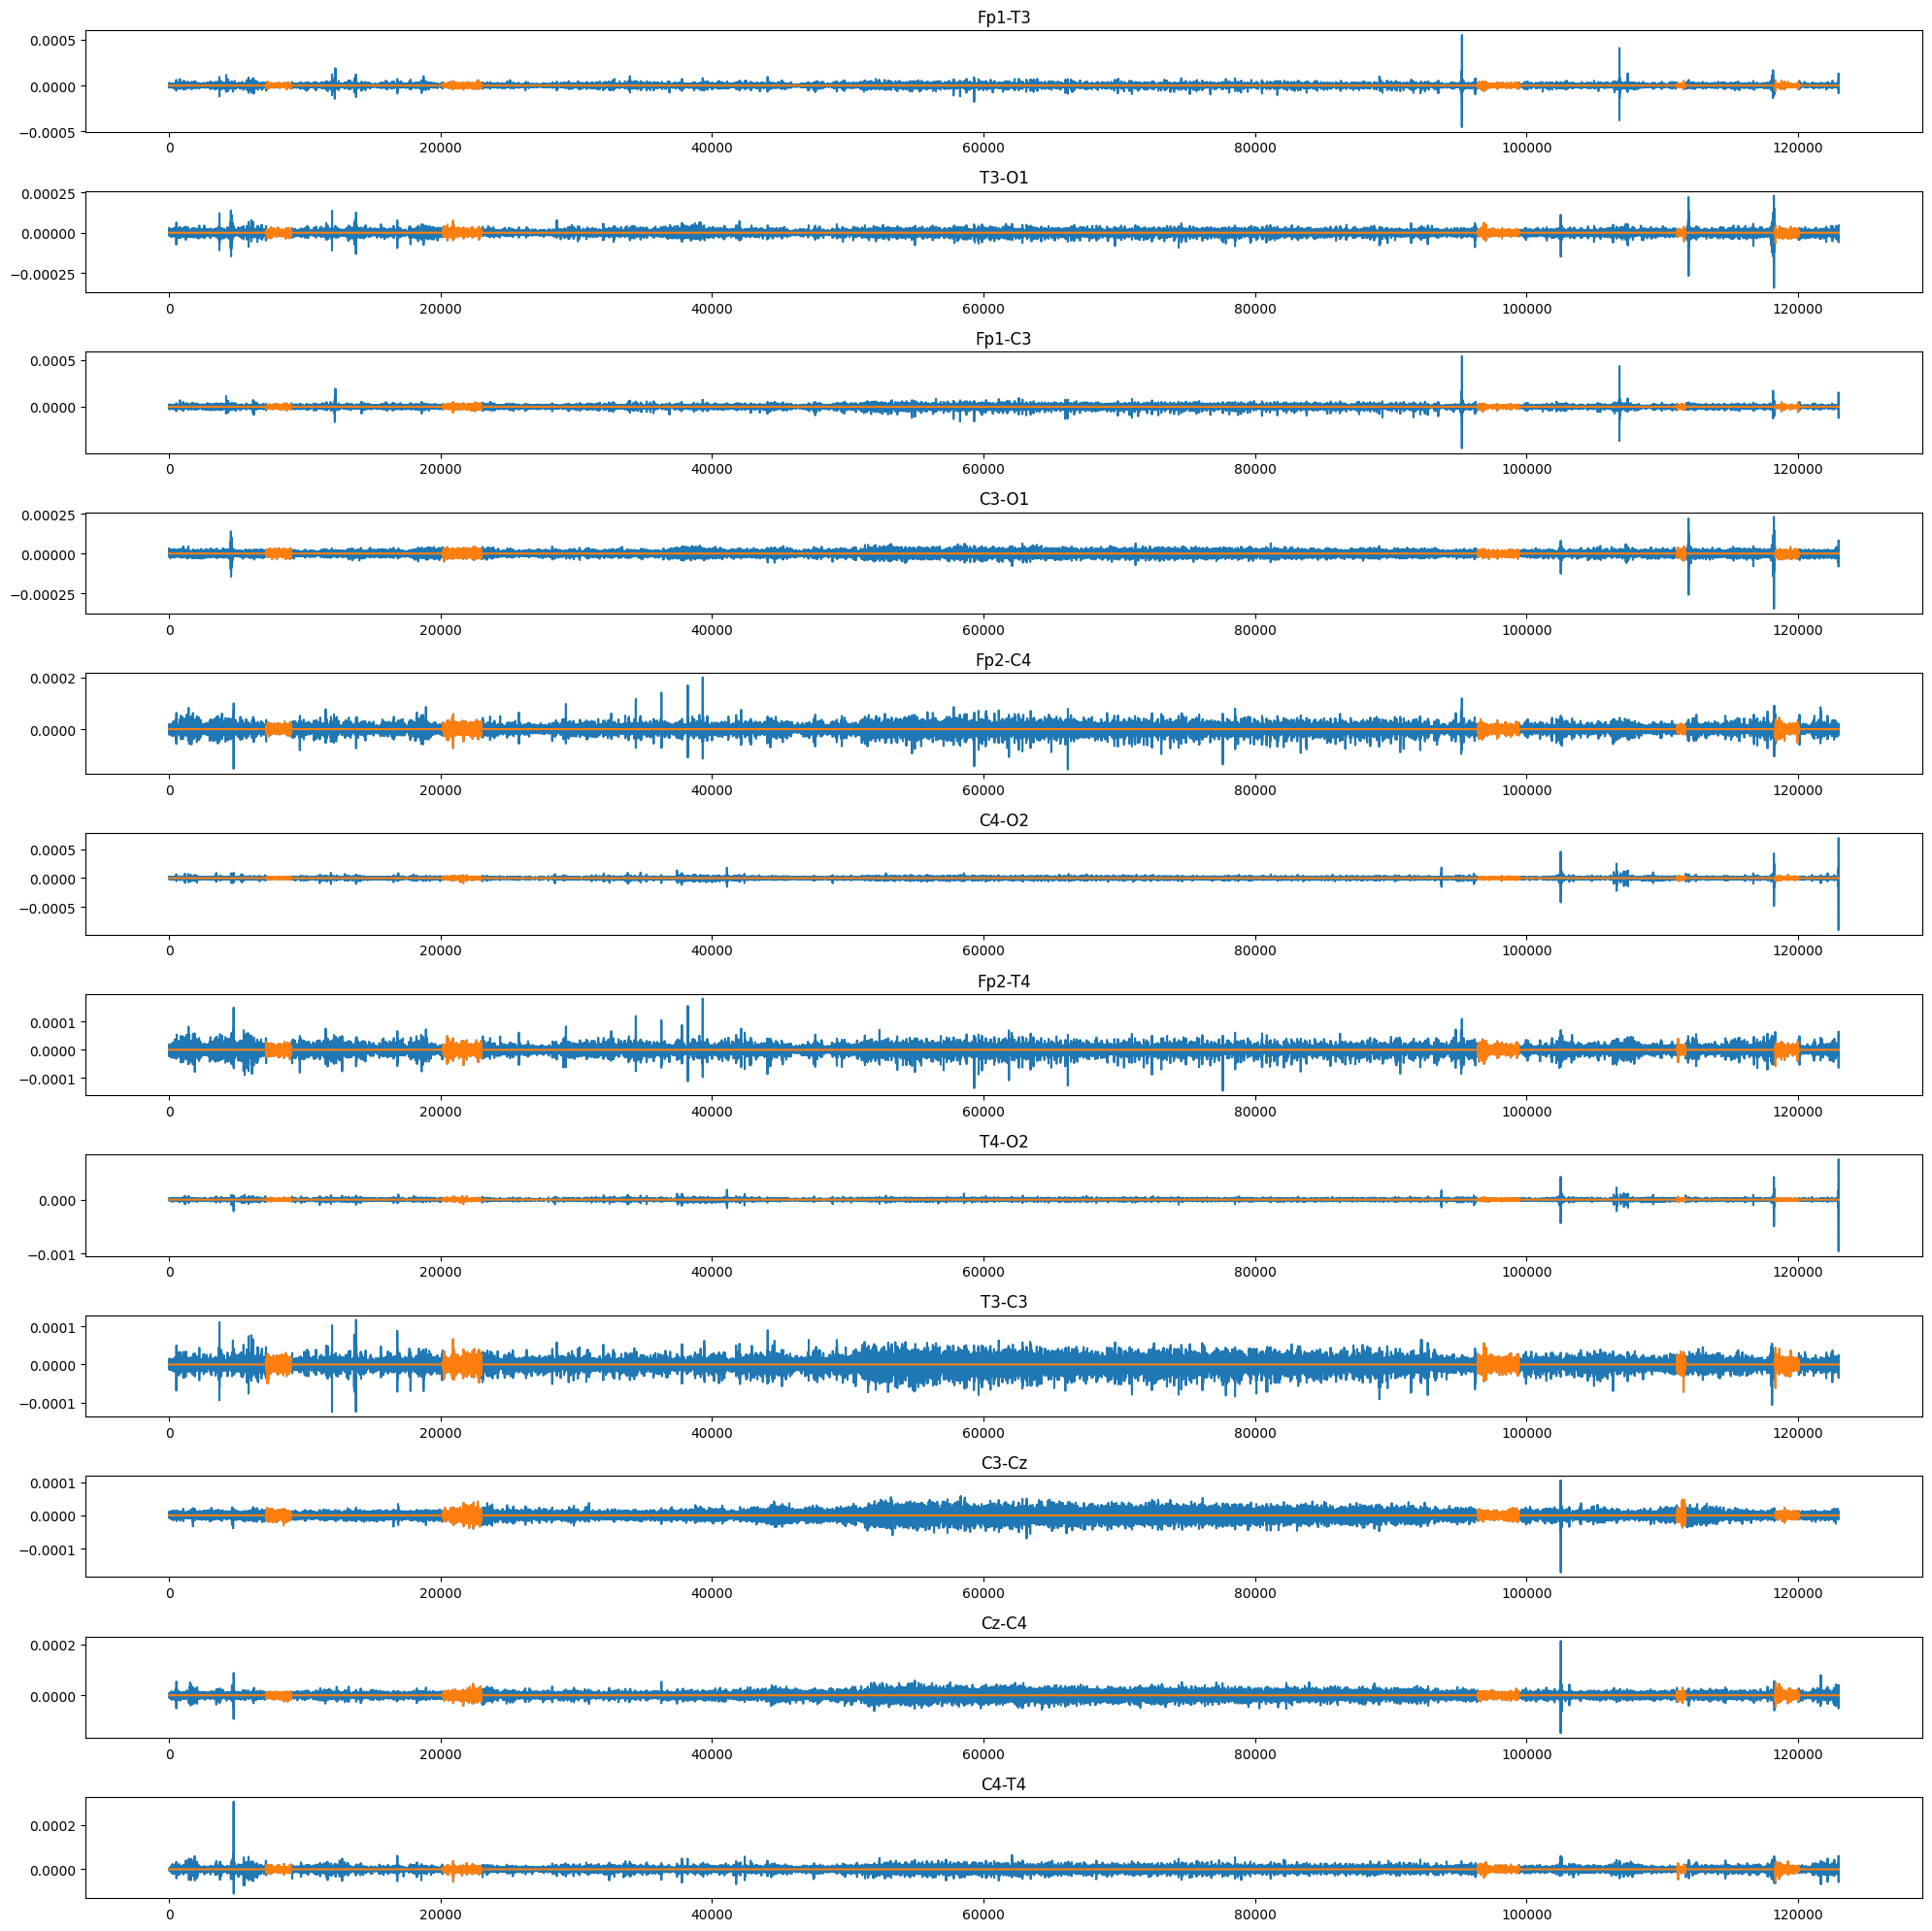

In [11]:
EEG,labels=rs.read_a_file("../BraiNeoCare/Datasets/zenodo_eeg/eeg22.edf",22,plot_=True)

In [3]:
model = keras.models.load_model("GAT_CV_6\cp_0012.ckpt")
model.layers[-1].activation = None

In [4]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 12, 384, 1)]         0         []                            
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 384, 32)          192       ['input_7[0][0]']             
                                                                                                  
 conv2d_49 (Conv2D)          (None, 12, 384, 32)          256       ['input_7[0][0]']             
                                                                                                  
 add_24 (Add)                (None, 12, 384, 32)          0         ['conv2d_48[0][0]',           
                                                                     'conv2d_49[0][0]']     

In [4]:
grad_model = keras.Model(model.inputs,[model.get_layer("gat_layer_20").output,model.output])

def PreprocesSignal(signal,mean,std):
    signal=(signal-mean)/std
    signal=np.expand_dims(signal,axis=-1)
    signal=np.expand_dims(signal,axis=0)
    return signal

def GradCAM(signal,model=grad_model):
    
    with tf.GradientTape() as tape:
        CNN_outputs, predictions = grad_model(signal)
        Class=predictions[:,0]

    grads = tape.gradient(Class, CNN_outputs)

    heatmap = CNN_outputs[0] * tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.nn.relu(heatmap)/tf.reduce_max(heatmap)
    # print(tf.reduce_mean(grads, axis=(0,1,2)))
    return heatmap.numpy(),tf.nn.sigmoid(predictions[0][0]).numpy()

In [5]:
mean,std=np.load("mean_std.npy")

In [12]:
631*32

20192

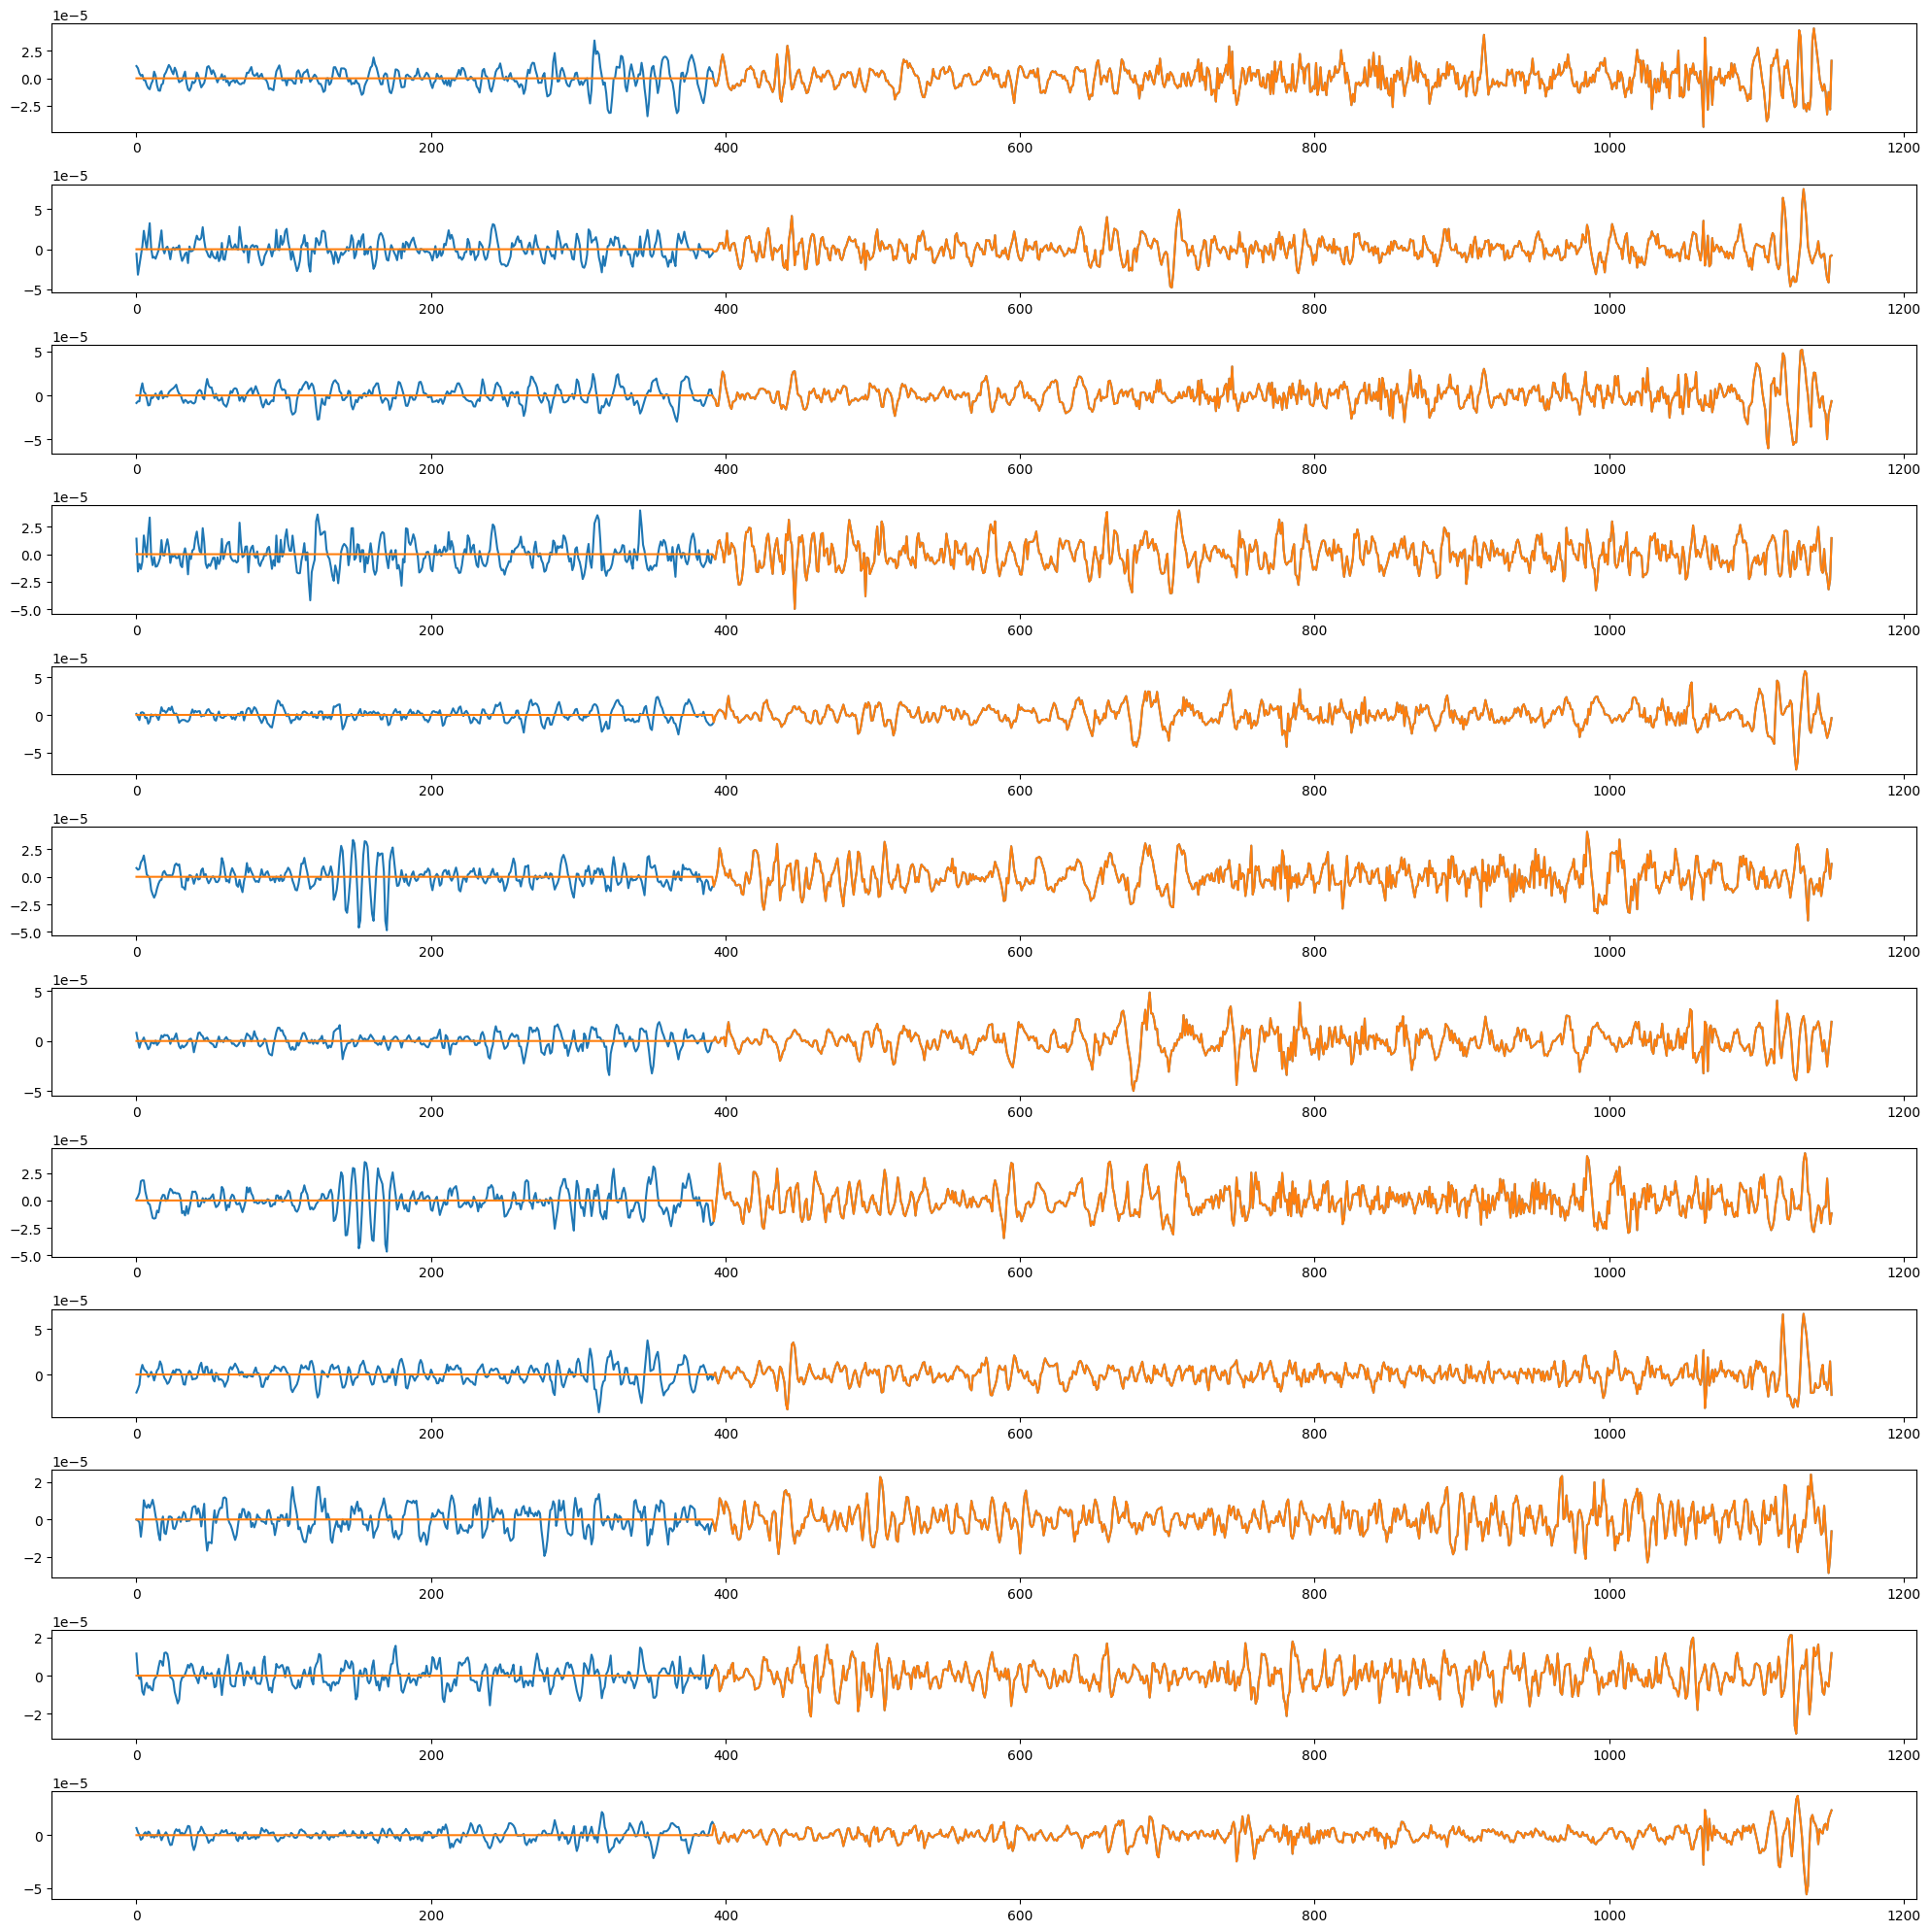

In [13]:
fig,ax=plt.subplots(12,1,figsize=(20,20))
lb=19800
ub=19800+36*32
for r in range(12):
    ax[r].plot(EEG[r][lb:ub])
    ax[r].plot(labels[r][lb:ub])
    # ax[r].set_title(channel_names[r])
fig.tight_layout()
plt.show()

prediction:-  0
prediction:-  1
prediction:-  1


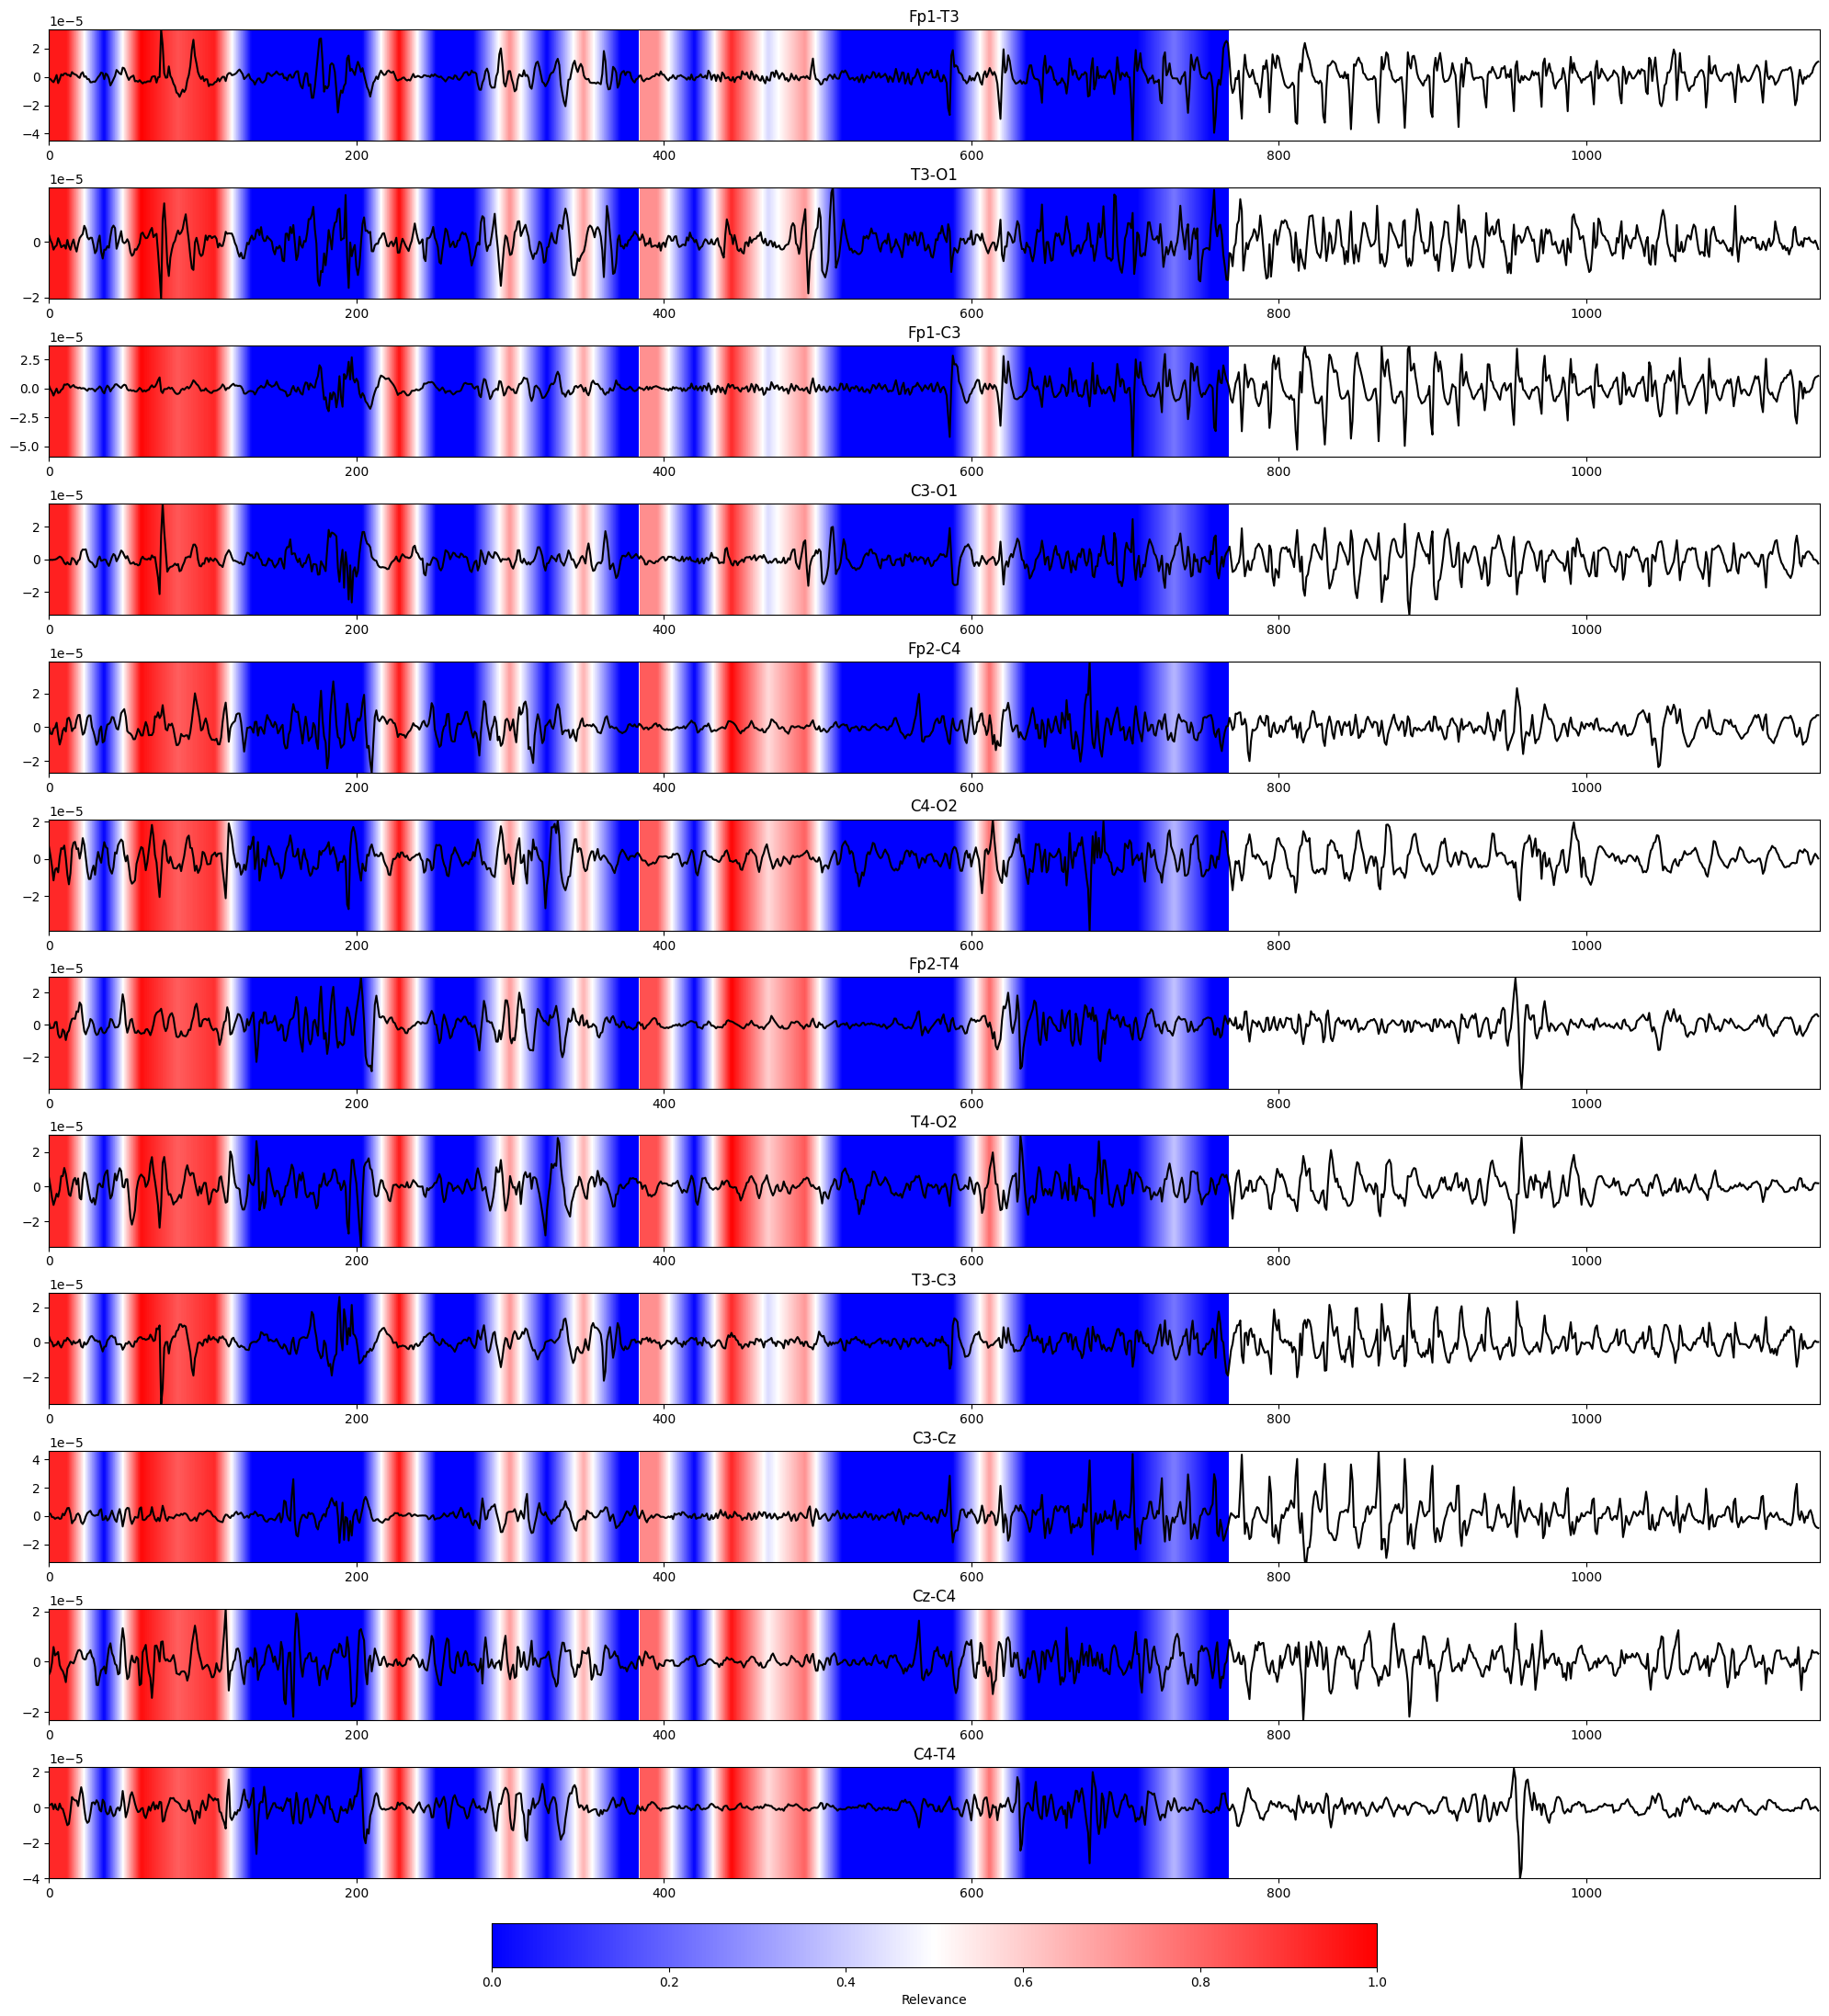

In [10]:
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
# n=3
l=64600
u=64600+1152
h_map=np.zeros((12,1152))
for r in range(3):
    lb=64600+384*r
    ub=64600+384*r+384
    x=PreprocesSignal(EEG[:,lb:ub],mean,std)
    h,p=GradCAM(x)
    print("prediction:- ",1 if p>=0.5 else 0)
    resized_heatmap = cv.resize(h, (384,12), interpolation=cv.INTER_LINEAR)
    h_map[:,384*r:384*r+384]=resized_heatmap
# h_map
fig,ax=plt.subplots(12,1,figsize=(20,25))
for r in range(12):
    ax[r].plot(EEG[r,l:u],color='k')
    im=ax[r].imshow(h_map[r].reshape(1,1152),cmap='bwr',alpha=1,extent=[0,1152,EEG[r,l:u].min(),EEG[r,l:u].max()],aspect='auto',vmax=1,vmin=0)
    ax[r].set_title(channel_names[r])   
fig.tight_layout()
cbar=fig.colorbar(im,ax=ax,orientation='horizontal',pad=0.02,shrink=0.5)
cbar.set_label('Relevance')
plt.show()